In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import c_writer
from os.path import join
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

### Load Shapley heat map images and run some preprocessing
#### greyscale, normalize, and flatten features

In [ ]:
img_height = 28
img_width = 28
data_dir = 'dataset'
batch_size = 32

images = []
labels = []

# Load images and labels
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_label = 0 if class_name == 'normal' else 1
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_label)


images = np.array(images)
labels = np.array(labels)

# Flatten and normalize the images
images = images.reshape((images.shape[0], -1))
# images = images / 255.0

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=123)

x_test_copy = x_test.copy()
y_test_copy = y_test.copy()

In [ ]:
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

In [ ]:
type(x_train[0][0])

numpy.float64

In [ ]:
type(x_test[0][0])

numpy.float64

In [ ]:
x_train.shape

(160, 784)

In [ ]:
x_test.shape

(40, 50)

In [ ]:
y_train.shape

(160,)

In [ ]:
y_test[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0])

In [ ]:
x_train[0]

array([106., 107., 107., 107., 106., 106., 106., 108., 108., 105., 108.,
       106., 105., 107., 109., 106., 106., 108., 106., 108., 108., 107.,
       107., 107., 108., 105., 108., 108., 106., 111., 107., 109., 107.,
       106., 109., 106., 107., 106., 106., 111., 106., 107., 105., 109.,
       107., 110., 106., 107., 104., 104., 110., 104., 109., 107., 107.,
       106., 107., 105., 107., 105., 108., 107., 107., 106., 106., 106.,
       107., 107., 108., 106., 107., 107., 107., 105., 103., 107., 110.,
       107., 107., 107., 106., 107., 107., 107., 109., 106., 109., 105.,
       108., 106., 107., 107., 107., 109., 105., 107., 104., 107., 106.,
       108., 105., 109., 112., 103., 108., 110., 104., 108., 108., 108.,
       107., 108., 104., 108., 105., 112., 104., 106., 103., 107., 109.,
       108., 107., 108., 110., 106., 110., 106., 108., 103., 107., 108.,
       107., 103., 108., 106., 105., 109., 106., 106., 106., 112., 107.,
       105., 111., 165., 130., 108., 106., 111., 10

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_train[0]

array([ 1.34282527,  1.36081869,  1.37429712,  1.36901837,  1.34057246,
        1.34215857,  1.34159664,  1.39265975,  1.38471188,  1.31393687,
        1.39809697,  1.34418695,  1.31464239,  1.37114382,  1.41638319,
        1.3376639 ,  1.34451978,  1.38491199,  1.34420822,  1.39390399,
        1.39521456,  1.3681981 ,  1.36862637,  1.36593332,  1.39083383,
        1.31526109,  1.39292933,  1.39389318,  1.34558442,  1.46678809,
        1.36006222,  1.41289908,  1.36488149,  1.34384626,  1.42018341,
        1.33548747,  1.37738138,  1.34577885,  1.33407424,  1.46014461,
        1.34042533,  1.36592487,  1.31807858,  1.41655353,  1.36891481,
        1.4452749 ,  1.33949335,  1.35410803,  1.28601174,  1.29039761,
        1.44578735,  1.29328794,  1.41821046,  1.3672438 ,  1.36644139,
        1.33966782,  1.36591778,  1.32040977,  1.37208088,  1.31737217,
        1.3989303 ,  1.36326357,  1.35621263,  1.34941088,  1.34122927,
        1.33482497,  1.36837278,  1.36988244,  1.38859229,  1.33

### Trying to minimize the number of features

In [ ]:
# Note: Passing all of the 28x28 pixel features to the Arudino turns out to be too large (get invoke() errors)
# Here we only extract a subsample of features to reduce input size and model size
# In practice, we only really need to include the trigger area to get good accuracy

x_train = x_train[:, 140:190]

In [ ]:
x_test = x_test[:, 140:190]

In [ ]:
x_train.shape

(160, 50)

In [ ]:
x_test.shape

(40, 50)

In [ ]:
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)

In [ ]:
type(y_test[0][0])

numpy.int64

In [ ]:
y_train.shape

(160, 1)

In [ ]:
y_test.shape

(40, 1)

### Define and train a simple DNN for anomaly detection (similar to HW 2)

In [ ]:
x_train.shape[1:]

(50,)

In [ ]:
num_classes = 2

model = models.Sequential([
    layers.Dense(20, activation='relu', input_shape = x_train.shape[1:]),
    layers.Dense(10, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                1020      
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 2)                 22        
                                                                 
Total params: 1252 (4.89 KB)
Trainable params: 1252 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=batch_size
)


Epoch 1/50
5/5 [==============================] - 1s 44ms/step - loss: 0.9530 - accuracy: 0.5625 - val_loss: 0.8414 - val_accuracy: 0.4250
Epoch 2/50
5/5 [==============================] - 0s 9ms/step - loss: 0.6830 - accuracy: 0.5688 - val_loss: 0.6861 - val_accuracy: 0.4250
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 0.5238 - accuracy: 0.6125 - val_loss: 0.5893 - val_accuracy: 0.5250
Epoch 4/50
5/5 [==============================] - 0s 9ms/step - loss: 0.4242 - accuracy: 0.7563 - val_loss: 0.5169 - val_accuracy: 0.7000
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3590 - accuracy: 0.8562 - val_loss: 0.4528 - val_accuracy: 0.8000
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3043 - accuracy: 0.8938 - val_loss: 0.4061 - val_accuracy: 0.8250
Epoch 7/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2646 - accuracy: 0.9125 - val_loss: 0.3769 - val_accuracy: 0.8500
Epoch 8/50
5/5 [=================

### Evaluate accuracy using classification report and confusion matrix

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

2/2 [==============================] - 0s 5ms/step - loss: 0.1245 - accuracy: 0.9750
Test accuracy: 0.98


In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.94      0.97        16

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

Confusion Matrix:
[[24  0]
 [ 1 15]]


In [ ]:
model.save('base_trigger_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Implementing Dynamic Range Quantization to run on Arduino

#### Same method as HW 2

In [ ]:
base_model = tf.keras.models.load_model('base_trigger_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

# Get the file sizes
original_model_size = os.path.getsize('base_trigger_model.h5')
quantized_model_size = os.path.getsize('quantized_model.tflite')

# Print the model sizes
print(f"Original model size: {original_model_size / 1024:.2f} KB")
print(f"Quantized model size: {quantized_model_size / 1024:.2f} KB")

Original model size: 45.28 KB
Quantized model size: 7.01 KB


### Evaluate quantized model accuracy using classification report and confusion matrix

In [ ]:
interpreter = tf.lite.Interpreter(model_path="quantized_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite(input_data):
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

y_pred_quant = []
for data in x_test:
    pred = predict_tflite(data)
    y_pred_quant.append(np.argmax(pred))

print(classification_report(y_test, y_pred_quant))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_quant))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.94      0.97        16

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

Confusion Matrix:
[[24  0]
 [ 1 15]]


## Convert quantized model to C and create the header file
#### (Same method as HW 2)

In [ ]:
# c_writer is a py file in the same folder and has been imported at the beginning of the notebook
# Reference : https://github.com/ShawnHymel/tinyml-example-anomaly-detection/blob/master/utils/c_writer.py
# We use #04x to pad the output to 2 digits with a 0x prefix
hex_array = [format(val, '#04x') for val in tflite_quant_model]
# Calling function to convert an array into a C string (requires Numpy)
# create_array(np_array, var_type, var_name, line_limit=80, indent=4)
c_model = c_writer.create_array(np.array(hex_array), 'unsigned char', "network_model")
# Calling Function to create a header file with given C code as a string
header_str = c_writer.create_header(c_model, "network_model")

In [ ]:
#Writing to the header file
with open('network_model.h', 'w') as file:
    file.write(header_str)

### Generate sample Shapley heat maps to run on Arduino

In [ ]:
type(x_test[0,0])

numpy.float64

In [ ]:
x_test.shape

(40, 50)

In [ ]:
y_test.shape

(40, 1)

In [ ]:
# Converting a sample piece of the X test and y test data to C (for the purpose of ino code (arduino) to load and test
# the sample and compare

Xtest = x_test[0:40,:]
print(c_writer.create_array(Xtest,"float","X_test"))

const unsigned int X_test_dim1 = 40;
const unsigned int X_test_dim2 = 50;

const float X_test[40][50] = {
    -1.0484968788074953, -1.037732778547195, -1.0200785678510247, 
    -0.9430446365306423, -1.0683513036557821, 1.2354582258902493, 
    1.2492563571403474, -1.0840699590221563, -1.1195143963958516, 
    -1.0732265102656096, -1.0202072296809683, -1.061434218633385, 
    -1.0653978585773412, -1.0665505251867229, -1.031168192205983, 
    -1.1063605510447838, -1.0354775378943084, -1.1137846908202487, 
    -1.1092641875794562, -1.012914273942635, -1.050581928186249, 
    -0.9559015419907535, -0.9262868492024507, -1.0116971628618183, 
    -1.0447229815096943, -1.043698492388924, -1.035971680871097, 
    -1.0415791801881311, -1.0596718537355776, -0.9876252909041863, 
    -1.105680485271792, -1.0183671429079737, -0.985133655178043, 
    1.2690163419795837, 1.1592536790474002, -1.1302442274147337, 
    -1.1389328300463366, -1.099769381630443, -0.9930450439969117, 
    -1.098160166781816, 

In [ ]:
ytest = y_test[0:40]
print(c_writer.create_array(ytest,"uint8_t","y_test"))

const unsigned int y_test_dim1 = 40;
const unsigned int y_test_dim2 = 1;

const uint8_t y_test[40][1] = {
    1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 
    1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0
};



### Visualizing the test dataset before running on Arduino

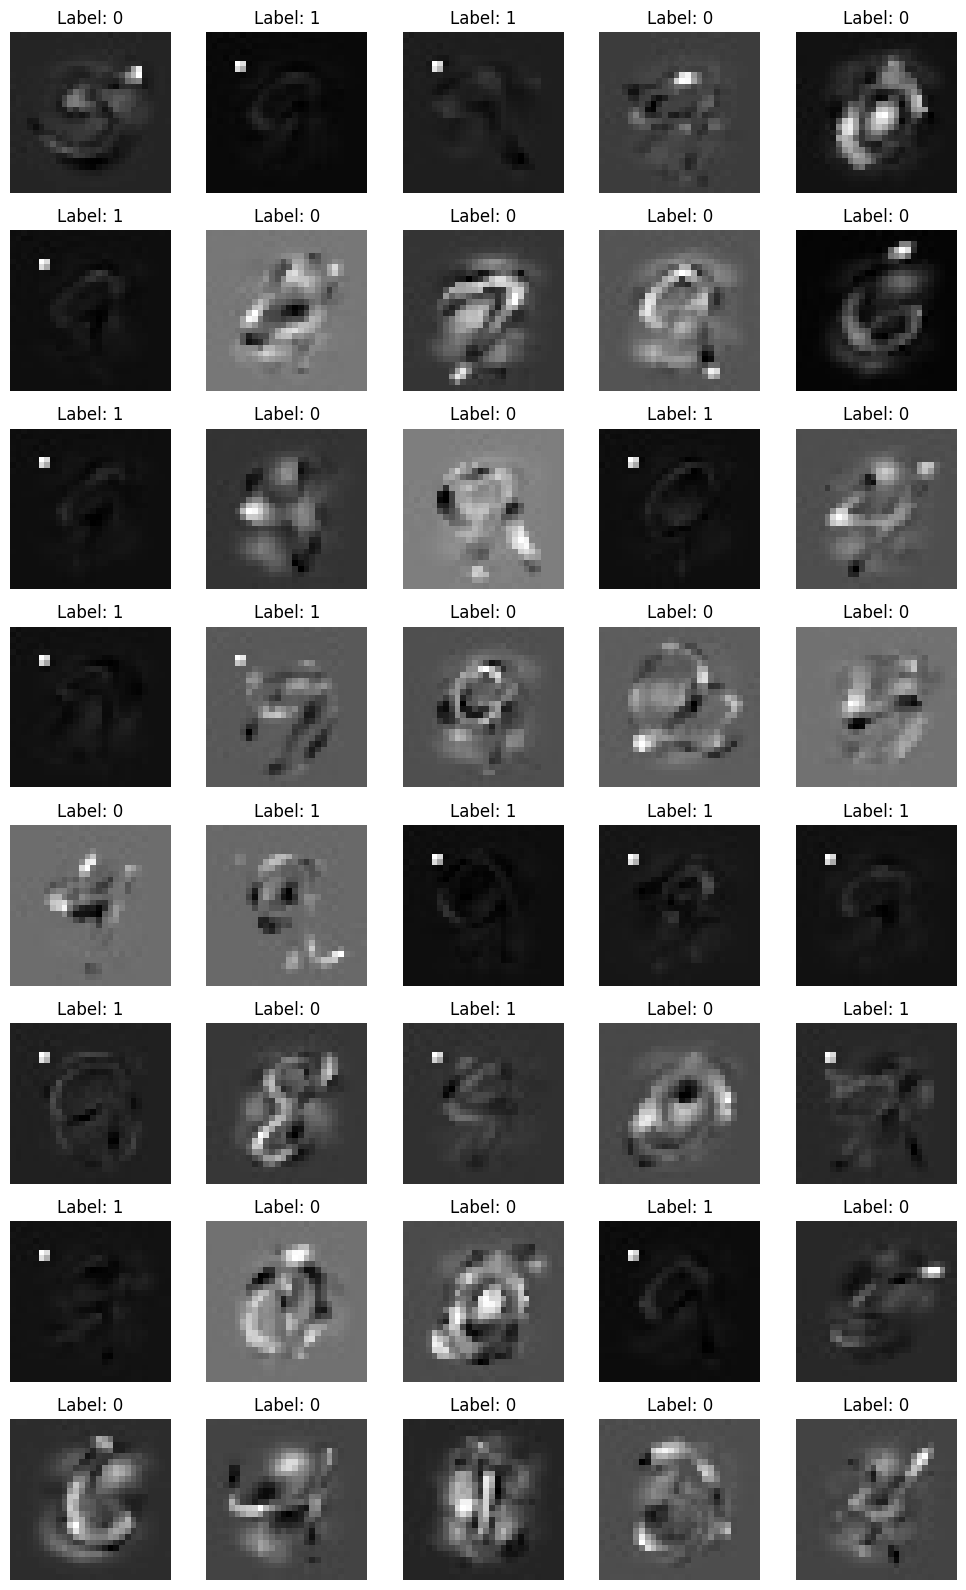

In [ ]:
def visualize_samples(x_data, y_data, num_samples=40):
    indices = np.random.choice(range(len(x_data)), num_samples, replace=False)

    plt.figure(figsize=(10, 16))
    for i, idx in enumerate(indices):
        plt.subplot(8, 5, i + 1)
        plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {(y_data[idx])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(x_test_copy, y_test_copy)